# 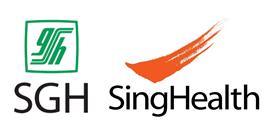

---



# Building LLM-based applications for clinician support

In this notebook, we will explore the application of Large Language Models to tackle different use cases in medical operations. We will learn how to call **OpenAI API** to streamline LLM-related tasks and have better control over text generation parameters. We will use **Langchain** library to construct Prompt recipes and incorporate Vector Database to help improve LLM's answer quality. <br><br>

There are three examples in this notebook:
* Example 1: OpenAI API for structured text extraction
* Example 2: Document summarization with Langchain
* Example 3: **Retrieval Augment Generation (RAG)** Question Answering with Langchain and FAISS Vector Database

# Install Packages Dependencies

- langchain: Main package for building LLM application
- openai: For use OpenAI LLM model as engine for application
- faiss-cpu: Facebook AI Similarity Search. Vector Database for document retrieval.
- tiktoken: Package for counting tokens consumed by LLMs. Support several LLMs including OpenAI and HuggingFace models.
- pypdf & PyMuPDF: Package for loading PDF documents.

In [1]:
!pip install openai langchain PyPDF tiktoken faiss-cpu PyMUPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.6/272.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.2 MB/s eta 0:00:00


Let's also setup our working directory and download sample data files for our examples. The data_files.zip includes 3 folders:
- Example 1: patients_summary.csv file containing patients summary
- Example 2: 4 transcripts of doctors - patients consultations.
- Example 3: 10 PDF documents containing guidelines for treatment of diseases

In [ ]:
%mkdir sgh_workshop # Create directory
%cd /content/sgh_workshop # Move into the directory

In [2]:
# Import basic package
import os
import pandas as pd
from typing import List, Dict, Union
from pprint import pprint

MAIN_DIR = os.getcwd() # Set Main Working Directory

/content/sgh_workshop


In [3]:
!pip3 install --upgrade gdown # Install google download package
!gdown https://drive.google.com/uc?id=1Hj-DVUycOyMzcEEc-40XkbZ7QMpYtWQw # Download data files from google drive
!unzip data_files.zip # Unzip file

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From: https://drive.google.com/uc?id=1jWcmOEDnN6yIYxblZHaoFUr2PDbbM3fA
To: /content/sgh_workshop/data_files.zip
100% 16.8M/16.8M [00:00<00:00, 167MB/s]
Archive:  data_files.zip
  inflating: example2/meeting_4.txt  
  inflating: example1/patients_summary.csv  
  inflating: example2/meeting_1.txt  
  inflating: example2/meeting_3.txt  
  inflating: example2/meeting_2.txt  
  inflating: example3/MSTF 2017 CRC Screening.pdf  
  inflating: example3/ASCRS 2017 Lynch Syndrome.pdf  
  inflating: example3/umj7603-154.pdf  
  inflating: example3/nihms-1069237.pdf  
  inflating: example3/AGA 2021 IBD CRC Surveillance.pdf  
  inflating: example3/USPSTF 2021 CRC Screening.pdf  
  inflating: example3/ACG 2015 Hereditary GI Cancers.pdf  
  inflating: example3/Chronic kidney disease in the elderly.pdf  
  inflating: example3/ckd_evaluation_c

# OpenAI API
- OpenAI API is one of the fastest and convenient ways which allow developers to use LLMs to build application.

- When provided with a text prompt, the API will generate a text completion with the aim of aligning with the provided pattern. You can guide its behavior by presenting a few illustrative examples of your desired output.

- To use OpenAI models, we need a working API-Key. You can register for your own key at https://openai.com/blog/openai-api. On your first registration, you will be given some free credits to try out the API.

- To make an API call, you need to provide the following:
1. List of messages: This will be used to construct an input prompt to the LLM. Each message can assume one role: system, user, assistant or function. This simulates a chat conversation between Human and AI which OpenAI model is fine-tuned on.

2. Model name: This define LLM architecture and weights.

3. Optional parameters: temperature, top_p, n, max_tokens, etc

- The output of an API call is a JSON object containing:
1. Generated output texts.

2. Tokens usage information

Let's start with a simple example to make an API call using OpenAI Python SDK

In [4]:
# Enter OpenAI Key

import openai
from getpass import getpass

openai.api_key = getpass(prompt='Please enter your OPENAI API KEY: ') # For secure password input
os.environ["OPENAI_API_KEY"] = openai.api_key # Set environment variable OPENAI_API_KEY

Please enter your OPENAI API KEY: ··········


We will simulate a simple Human-AI conversation and ask GPT-3.5 model to provide us with a few jokes.

When using the API, we have control over text generation parameters to determine LLMs' text generation behaviour.

Some key parameters for OpenAI API:
- **model**: Name of the model. Commonly used models are **gpt-3.5-turbo** and **gpt-4**. For a full list of models, refer to [OpenAI Model Offerings](https://platform.openai.com/docs/models)

- **temperature**: defines the degree of randomness of the answer by altering the probability distribution of the generated tokens. Lower temperature means more deterministic and higher temperature means more random.

- **top_p**: Nucleus sampling where the model only considers the tokens with top_p probability mass. [The Curious Case of Neural Text Degeneration](https://arxiv.org/abs/1904.09751).

- **max_tokens**: Maximum tokens to be generated. In general, sum of prompt tokens and maximum generated tokens must be smaller than the maximum context length of the LLM.

- **n**: Number of answers to be generated.
- **presence_penalty** and **frequency_penalty**: Parameters to discourage using repetitive words.

There is a great article by **Lilian Weng** [Controllable neural text generation. Lil’Log](https://lilianweng.github.io/posts/2021-01-02-controllable-text-generation/) which explains in depth about text generation parameters and how to control them.

For more details about OpenAI API, refer to [OpenAI API Reference](https://platform.openai.com/docs/api-reference)

In [5]:
messages = [
    {"role": "user", "content": "Hello Chat GPT"},
    {"role": "assistant", "content": "Hi how can I help you"},
    {"role": "user", "content": "My Name is Quan. Tell me a joke."}
    ]

responses = openai.ChatCompletion.create(
    model = "gpt-3.5-turbo",
    messages = messages,
    max_tokens = 512,
    temperature = 0,
    n = 3
) # API Call to OpenAI server

In [6]:
responses

<OpenAIObject chat.completion id=chatcmpl-7v3iJOj0azFDZ6vQLfXDmeor1uYlD at 0x7d6d13c25990> JSON: {
  "id": "chatcmpl-7v3iJOj0azFDZ6vQLfXDmeor1uYlD",
  "object": "chat.completion",
  "created": 1693833327,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "Sure, Quan! Here's a joke for you:\n\nWhy don't scientists trust atoms?\n\nBecause they make up everything!"
      },
      "finish_reason": "stop"
    },
    {
      "index": 1,
      "message": {
        "role": "assistant",
        "content": "Sure, Quan! Here's a joke for you:\n\nWhy don't scientists trust atoms?\n\nBecause they make up everything!"
      },
      "finish_reason": "stop"
    },
    {
      "index": 2,
      "message": {
        "role": "assistant",
        "content": "Sure, Quan! Here's a joke for you:\n\nWhy don't scientists trust atoms?\n\nBecause they make up everything!"
      },
      "finish_reason": "stop"
    }
  ],
  

As you can see, with **temperature = 0**, we get the exact same content from all 3 answers. <br><br>
Let's try to set a higher temperature. But before that, to make things easier, we will create a simple Python function which do the following:

1. Make the API call based on the input message (prompt)

2. Extract and return the answers from JSON objects

3. Print the number of tokens used.

In [7]:
def get_chatcompletion(
    messages: List[Dict],
    model: str = "gpt-3.5-turbo",
    temperature: float = 0.7,
    max_tokens: int = 512,
    top_p: float = 1.0, # Nucleus Sampling. Only select top p% for sampling at decoding.
    n: int = 1,
) -> Union[List[str], str]:
    """This function makes API call to OpenAI and extract the content of the answers from response JSON object,

    Args:
        messages (List): List of messages. A message is a dictionary object containing role and content.
        model (str, optional): LLM Model to be used for text generation. Defaults to "gpt-3.5-turbo".
        temperature (float, optional): Temperature Parameter. Value can be between 0 and 2. Higher temperature 
            means more random, lower temperature means more deterministic. Defaults to 0.7.
        max_tokens (int, optional): Maximum number of tokens set aside for text generation. Defaults to 512.
        top_p (float, optional): Top p percents of tokens to be used during token sampling (nucleus sampling). Defaults to 1.0.

    Returns:
        Union[List[str], str]: response message or list of response messages from OpenAI API.
    """

    response = openai.ChatCompletion.create(
        model = model,
        messages = messages,
        max_tokens = max_tokens,
        temperature = temperature,
        top_p = top_p,
        n = n,
    )

    tokens_used = response["usage"] # Return how many tokens have been used on the API call
    print("Tokens used: Input: {}, Output: {}, Total: {}".format(tokens_used["prompt_tokens"], tokens_used["completion_tokens"], tokens_used["total_tokens"]))

    return [answer["message"]["content"] for answer in response["choices"]] if len (response["choices"]) > 1 else response["choices"][0]["message"]["content"]

In [8]:
humorous_answers = get_chatcompletion(
    messages = messages,
    model = "gpt-3.5-turbo",
    temperature = 1.7,
    max_tokens = 256,
    n = 3
)

Tokens used: Input: 30, Output: 80, Total: 110


In [9]:
humorous_answers

["Sure, here's a lighthearted joke for you: \n\nWhy don't scientists trust atoms? \n\nBecause they make up everything!",
 "Sure, Quan! Here you go:\nWhy couldn't the bicycle stand up by itself?\nBecause it was two-tired!",
 "Sure, Quan! Here's a joke for you:\n\nWhy don't scientists trust atoms?\n\nBecause they make up everything!"]

We can see that when we set the temperature = 0, all the 3 answers we got are identical, but when we set a higher temperature, there are some differences to the sequences of texts being generated by the API

# Example 1: Structure Data Extraction from patients summary using OpenAI API

In this example, we will apply OpenAI GPT API to extract key entities from patients' summaries. The patients summaries can be very messy containing many abbrevations, slangs and misspellings, making traditional Regular Expression and NLP approaches difficult.
Large Language Models, however, having been trained on huge corpus are less susceptible to these problems.

We will use OpenAI GPT to process the unstructured text, extract relevant information and convert it into more structured format which can be extracted with Regular Expression.

1. Prompt Construction: We will follow Role/Task/Output Instructions/Context/Example/Question template

2. OpenAI API: Convert unstructured text into more structured text

3. Regex: Convert structured text into structured data object (JSON & Tabular CSV)

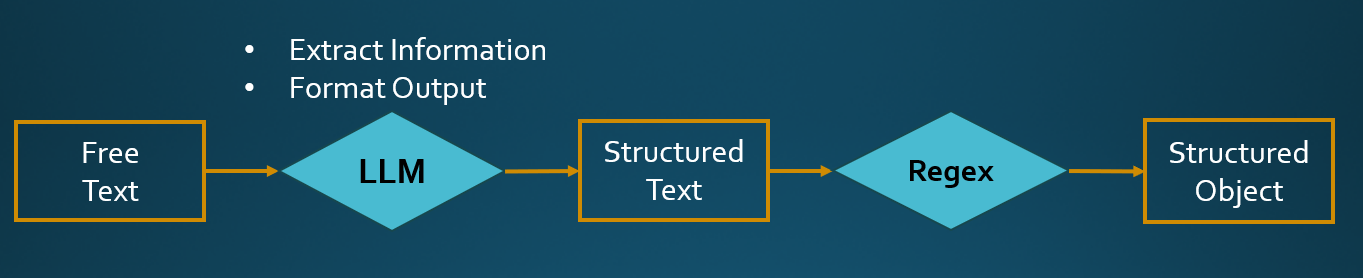

## Prompt Construction

In [10]:
## SYSTEM PROMPT
system_prompt = """You are an honest medical officer. If you don't know the answer, return None or "I don't know", don't try to make up an answer.
=========================
TASK: Analyse the given patient summary and extract the following information
- Age
- Ethnicity
- Gender
- Drug Allergy
- Smoking Status
- Drinking Status
- History of Diabetes
- History of Hypertension
- History of Heart Conditions

If the information is not present in the patient summary, return "NO"
========================
OUTPUT INSTRUCTION:
Return your answer in the following format
- Age: Single Integer
- Ethnicity: One of [Chinese, Malay, Indian, Others]
- Gender: One of [YES, NO]
- Drug Allergy: One of [YES, NO]
- Smoking Status: One of [YES, NO]
- Drinking Status: One of [YES, NO]
- History of Diabetes: One of [YES, NO]
- History of Hypertension: One of [YES, NO]
- History of Heart Conditions: One of [YES, NO]
=======================
EXAMPLES:
PATIENT PROFILE: 46 year old Chinese gentleman  no known drug allergy  ADL independent, community ambulant walking stick  smoker, 10 sticks/day; started 25 years ago  Non-drinker  Married, Currently unemployed    Past Medical History  1. Ischaemic Heart Disease ICD implanted for primary prevention 2. Parxoysmal AF  - noted episodes of pAF and NSVT in Feb 2015  - subsequently commenced on amiodarone  4. Diabetes Mellitus  - complicated by nephropathy - HbA1c - 6.2%.  5. Hypertension  6. Hyperlipidemia 7. Anaemia  8. Major Depressive Disorder   - diagnosed in 2016,  - started on Fluvoxamine 25 mg ON  - defaulted outpatient follow up.
ANSWER:
- Age: 46
- Ethnicity: Chinese
- Gender: Male
- Drug Allergy: NO
- Smoking Status: YES
- Drinking Status: NO
- History of Diabetes: YES
- History of Hypertension: YES
- History of Heart Conditions: YES
=======================
"""


## HUMAN PROMPT
human_prompt = """
PATIENT PROFILE: 67 year old CHI lady  NKDA  non smoker, non drinker  ADL independent, comm ambulant. PREV HIST: 1) Diabetes mellitus, last HbA1c 5.8%, normal creatinine clearance, basline Cr normal 2) Hypertension F/U OPS  3) Prev S/B NHC for chest pain  4) Fe deficiency anemia Basline Hb ~10
"""

## API Call

In [11]:
extraction_messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": human_prompt}
    ]

In [12]:
extraction_answers = get_chatcompletion(
    messages = extraction_messages,
    model = "gpt-3.5-turbo",
    temperature = 0.0,
    max_tokens = 512,
    n = 1
)

Tokens used: Input: 581, Output: 59, Total: 640


In [ ]:
print(extraction_answers)

- Age: 67
- Ethnicity: Chinese
- Gender: Female
- Drug Allergy: NO
- Smoking Status: NO
- Drinking Status: NO
- History of Diabetes: YES
- History of Hypertension: YES
- History of Heart Conditions: YES


In [13]:
## HUMAN PROMPT
human_prompt = """
79 yo/Malay/Male    ===PMH===  1. Diabetes Mellitus Type 2    - on insulin  2. IHD/CAD    - s/p CABG 3. Chronic Kidney Disease secondary to DM Nephropathy    - baseline Crea 142; 4. HTN  5. Hyperlipidemia  6. Pulmonary TB    - completed treatment in 2009  7. Perforated PUD (Sept 2010)    - pre-pyloric area
"""

extraction_messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": human_prompt}
    ]

extraction_answers = get_chatcompletion(
    messages = extraction_messages,
    model = "gpt-3.5-turbo",
    temperature = 0.0,
    max_tokens = 512,
    n = 1
)

print(extraction_answers)

Tokens used: Input: 596, Output: 59, Total: 655
- Age: 79
- Ethnicity: Malay
- Gender: Male
- Drug Allergy: NO
- Smoking Status: NO
- Drinking Status: NO
- History of Diabetes: YES
- History of Hypertension: YES
- History of Heart Conditions: YES


## Post Processing

With the structured text generated by GPT, we now can use Regular Expression to extract the necessary information.

Here we create a function that take in generated GPT answers and format them into a Dictionary data structure which we will in our pipeline

In [14]:
import re # Import rule-based text processing package

def format_answer(
    answer: str
) -> Dict:
    output = {}
    age_pattern = r"Age: ([0-9]+)\b|$"
    output["Age"] = int(re.search(age_pattern, answer).group(1))
    for cat in ["Ethnicity", "Gender", "Drug Allergy", "Smoking Status", "Drinking Status", "Diabetes", "Hypertension", "Heart Conditions"]:
        pattern = f"{cat}" + r": ([a-zA-z]+)\b|$"
        output[cat] = re.search(pattern, answer).group(1)

    return output

## Scale up to many patient summaries

Now that we have a working example, we can use it to create a pipeline that takes in a csv file containing many free texts and return the csv files with additional columns containing the structured data that we extracted with OpenAI GPT.

In [15]:
test_cases = pd.read_csv(os.path.join(MAIN_DIR, "example1", "patients_summary.csv")) # Read in .csv file

raw_answers = [] # List to store raw generated answers from GPT
structured_answers = [] # List to store post-processed answers after regular expression
for test_case in test_cases["Free Text"]: # Loop through all the free text in csv file
    human_prompt = "PATIENT PROFILE: " + test_case # Add the free-text into prompt
    extraction_messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": human_prompt}
        ]
    answer = get_chatcompletion(extraction_messages) # Make API Call to OpenAI
    raw_answers.append(answer)
    structured_answers.append(format_answer(answer)) # Post-Processing with Regular Expression

Tokens used: Input: 660, Output: 59, Total: 719
Tokens used: Input: 584, Output: 59, Total: 643
Tokens used: Input: 600, Output: 59, Total: 659
Tokens used: Input: 756, Output: 59, Total: 815
Tokens used: Input: 703, Output: 59, Total: 762
Tokens used: Input: 901, Output: 59, Total: 960
Tokens used: Input: 603, Output: 59, Total: 662
Tokens used: Input: 595, Output: 59, Total: 654
Tokens used: Input: 633, Output: 59, Total: 692
Tokens used: Input: 563, Output: 59, Total: 622
Tokens used: Input: 641, Output: 59, Total: 700
Tokens used: Input: 556, Output: 59, Total: 615


In [ ]:
structured_answers

[{'Age': 46,
  'Ethnicity': 'Chinese',
  'Gender': 'Male',
  'Drug Allergy': 'NO',
  'Smoking Status': 'YES',
  'Drinking Status': 'NO',
  'Diabetes': 'YES',
  'Hypertension': 'YES',
  'Heart Conditions': 'YES'},
 {'Age': 67,
  'Ethnicity': 'Chinese',
  'Gender': 'Female',
  'Drug Allergy': 'NO',
  'Smoking Status': 'NO',
  'Drinking Status': 'NO',
  'Diabetes': 'YES',
  'Hypertension': 'YES',
  'Heart Conditions': 'YES'},
 {'Age': 79,
  'Ethnicity': 'Malay',
  'Gender': 'Male',
  'Drug Allergy': 'NO',
  'Smoking Status': 'NO',
  'Drinking Status': 'NO',
  'Diabetes': 'YES',
  'Hypertension': 'YES',
  'Heart Conditions': 'YES'},
 {'Age': 56,
  'Ethnicity': 'Chinese',
  'Gender': 'Male',
  'Drug Allergy': 'NO',
  'Smoking Status': 'NO',
  'Drinking Status': 'NO',
  'Diabetes': 'YES',
  'Hypertension': 'YES',
  'Heart Conditions': 'YES'},
 {'Age': 38,
  'Ethnicity': 'Indian',
  'Gender': 'Female',
  'Drug Allergy': 'NO',
  'Smoking Status': 'NO',
  'Drinking Status': 'NO',
  'Diabetes': 

## Output as csv file

In [ ]:
col_names = ["Age", "Ethnicity", "Gender", "Drug Allergy", "Smoking Status", "Drinking Status", "Hypertension", "Heart Conditions"]
for col_name in col_names:
    test_cases[col_name] = [answer[col_name] for answer in structured_answers]

test_cases.to_csv("patients_summary_extracted.csv", header=True) # Write to .csv files on disk
test_cases

,Free Text,Age,Ethnicity,Gender,Drug Allergy,Smoking Status,Drinking Status,Hypertension,Heart Conditions
0,46 year old Chinese gentleman no known drug a...,46,Chinese,Male,NO,YES,NO,YES,YES
1,"67 year old CHI lady NKDA non smoker, non dr...",67,Chinese,Female,NO,NO,NO,YES,YES
2,79 yo/Malay/Male ===PMH=== 1. Diabetes Mel...,79,Malay,Male,NO,NO,NO,YES,YES
3,"56/Male/Chinese Production worker-computers, ...",56,Chinese,Male,NO,NO,NO,YES,YES
4,38 y old Indian Female NKDA ADL- independen...,38,Indian,Female,NO,NO,NO,YES,YES
5,52 year old/Chi/M Stays alone SIngle Pas...,52,Chinese,Male,NO,NO,NO,YES,YES
6,63 year old chinese male NKDA ADL independ...,63,Chinese,Male,NO,NO,NO,YES,NO
7,78 year old Chinese male NKDA non smoker non...,78,Chinese,Male,NO,NO,NO,YES,NO
8,"56yo/Chinese/Male allergic to ciprofloxacin, ...",56,Chinese,Male,YES,NO,NO,NO,NO
9,64 y old female ADL I cook nonsmoker non...,64,NO,Female,NO,NO,NO,NO,YES


# Example 2: Text Summarization with OpenAI API & Langchain

In this example, we will summarize the transcripts of the long conversations between a doctor and a patient. This application will help doctor to quickly review a patient profile, historical conditions and previous treatment plans.

In this example, we will use Langchain library to create a function that takes it document files containing the transcripts of the conversation and generate the summaries of one or more conversations.



In [19]:
from langchain.chains.summarize import load_summarize_chain
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader

## Load Data

In [17]:
document_paths = [os.path.join(MAIN_DIR, "example2", file_path) for file_path in os.listdir(os.path.join(MAIN_DIR, "example2"))] # Generate the list of paths to all doc

all_meetings = []
for document_path in document_paths:
    all_meetings.extend(TextLoader(document_path, encoding = "utf8").load()) # TextLoader Module will read the content of the text files 

print("Number of loaded document:", len(all_meetings))

Number of loaded document: 4


Let's inspect the content of one text file

In [18]:
first_meeting = all_meetings[0]
print(first_meeting.page_content)

======DATE: 12-Jan-2023======

Doctor: Good morning. It's nice to see you again. How have you been feeling since our last meeting?

Patient: Good morning, Doctor. I've been feeling okay, just a bit anxious about the results.

Doctor: Understandably so. Let's get straight to it then. As I explained earlier, we conducted a colonoscopy to screen for any abnormalities in your colon and rectum. During the procedure, we found and removed some polyps.

Patient: Polyps? What exactly does that mean?

Doctor: Polyps are abnormal growths that can develop in the colon lining. They vary in size and most of them are benign, which means they are not cancerous. However, some can become cancerous over time if left untreated.

Patient: So, do I have cancer?

Doctor: It's too early to definitively say. The removed polyps have been sent to the lab for a biopsy, which is a detailed examination under a microscope to determine if they are benign, precancerous, or cancerous.

Patient: What happens if they are

## Create Summarization Chain

To create a Summarization Chain, simple create an LLM object and feed into **load_summmarize_chain** function.

Under the hood, the Summarization Chain executes the following:
1. Take in a list of **Document** objects and insert the texts into the prompt.

2. Send an API call (or run local LLM model) to the API Service embedded inside the LLM object with the generated prompt.

3. Return the content of the API response

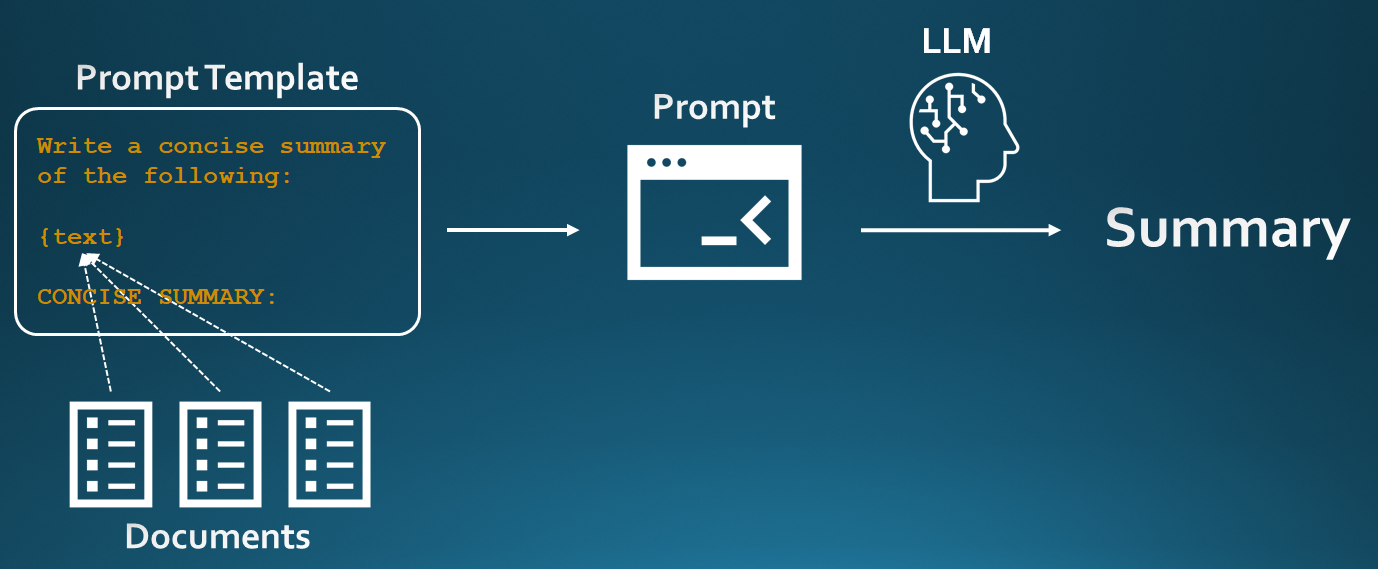

In [26]:
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, max_tokens=512) # Setup LLM Object
summarize_chain = load_summarize_chain(llm = llm, chain_type = "stuff", verbose = True) # Setup summarization_chain. We will use Langchain default prompt in this case

summary_1 = summarize_chain([first_meeting]) # Send API request & extract content of API response



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"======DATE: 12-Jan-2023======

Doctor: Good morning. It's nice to see you again. How have you been feeling since our last meeting?

Patient: Good morning, Doctor. I've been feeling okay, just a bit anxious about the results.

Doctor: Understandably so. Let's get straight to it then. As I explained earlier, we conducted a colonoscopy to screen for any abnormalities in your colon and rectum. During the procedure, we found and removed some polyps.

Patient: Polyps? What exactly does that mean?

Doctor: Polyps are abnormal growths that can develop in the colon lining. They vary in size and most of them are benign, which means they are not cancerous. However, some can become cancerous over time if left untreated.

Patient: So, do I have cancer?

Doctor: It's too early to definitively say. The removed polyps have been sent to the lab for a bio

In [22]:
summary_1["output_text"]

'The doctor informs the patient that during a colonoscopy, polyps were found and removed. The polyps have been sent for biopsy to determine if they are benign, precancerous, or cancerous. The doctor explains that further tests and treatments will be necessary depending on the results. The patient will receive the biopsy results in about a week and the doctor reassures them that they will discuss the next steps and provide support throughout the process.'

In [23]:
print(summarize_chain.llm_chain.prompt.template)

Write a concise summary of the following:


"{text}"


CONCISE SUMMARY:


### **Note**: PromptTemplate Placeholders

In Langchain, an important component is Prompt Template/Recipe. This allows prompt creation to be more structured and reproducible, especially in cases which we want combining multiple chains together in an application pipeline.

A Placeholder in Langchain can be created using curly brackets. For example, in the example PromptTemplate above, **text** is the placeholder which will be used by the summarization chain to insert documents during prompt creation.

**Tips**: To use literal curly brackets inside a Langchain PromptTemplate, use double curly brackets **{{** and **}}** instead of single curly brackets.

## Custom Summarization Prompt

In the example above, the LLM did produce a concise summarization of the conversation. However, in the process, a lot of details have been ignored in the summarization process which we may have wanted to capture such as patients age, medical history and living habits.

To have more control over the LLM output, let's create a custom PromptTemplate so we can ask LLM to produce exactly what we want.

Let's apply Role/Task/Output Instruction/Context/Examples/Question framework where applicable when we create the template.

In [24]:
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

system_prompt = """You are an honest and detail-oriented AI Medical Assistant. If you do not know the answers, just say I don't know, do not make up an answer.
=========================
TASK: Your task is to summarize the conversation between the doctor and the patient for doctors' future refence for treatments/recommendations.
Note that your summary should be concise while including details on patients and treatments.
========================
OUTPUT INSTRUCTION: Your summary should include, if applicable:
- Patient's details such as age, gender, ethnicity and family member history
- Living habit such as eating, drinking, smoking
- Previous medical conditions, treatment, medication
- Current Symptoms & Treatment recommendation.

Keep your summary in fewer than 300 words.
=======================
"""

human_prompt = """
CONVERSATION:
{text}
"""

custom_summarize_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(system_prompt),
        HumanMessagePromptTemplate.from_template(human_prompt)
    ]
)

In [25]:
custom_summarize_chain = load_summarize_chain(
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, max_tokens=512),
    prompt = custom_summarize_prompt,
    chain_type = "stuff",
    verbose = True)

In [27]:
custom_summary_1 = custom_summarize_chain([first_meeting])



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: You are an honest and detail-oriented AI Medical Assistant. If you do not know the answers, just say I don't know, do not make up an answer.
TASK: Your task is to summarize the conversation between the doctor and the patient for doctors' future refence for treatments/recommendations.
Note that your summary should be concise while including details on patients and treatments.
OUTPUT INSTRUCTION: Your summary should include, if applicable:
- Patient's details such as age, gender, ethnicity and family member history
- Living habit such as eating, drinking, smoking
- Previous medical conditions, treatment, medication
- Current Symptoms & Treatment recommendation.

Keep your summary in fewer than 300 words.

Human: 
CONVERSATION:
======DATE: 12-Jan-2023======

Doctor: Good morning. It's nice to see you again. How have you been feeling since our last meeting?

Patient: Good morni

In [ ]:
print(custom_summary_1["output_text"])

SUMMARY:

Patient Details: The patient is a 55-year-old individual who is generally in good health. They have no previous history of similar symptoms or major health issues. The patient's father had colon cancer in his late 60s.

Current Symptoms: The patient has been experiencing sharp abdominal pain in the lower part of the abdomen for about two weeks. They have also noticed blood in their stool.

Recommendation: Considering the patient's age, symptoms, and family history of colon cancer, the doctor recommends a colonoscopy to investigate the possibility of polyps in the colon. The procedure will allow for a thorough examination of the colon and rectum to check for any abnormalities. If polyps are found, they can be removed during the procedure for biopsy. The patient will be sedated during the procedure, which usually takes about 30 minutes to an hour. The removed polyps will be sent to the lab for analysis to determine their nature (benign, precancerous, or cancerous). Further trea

## Summarization over all documents

We can ask LLM to summarize over several documents by simply inputing all documents as a List to a summarization chain.

In [29]:
custom_summary_all = custom_summarize_chain(all_meetings)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: You are an honest and detail-oriented AI Medical Assistant. If you do not know the answers, just say I don't know, do not make up an answer.
TASK: Your task is to summarize the conversation between the doctor and the patient for doctors' future refence for treatments/recommendations.
Note that your summary should be concise while including details on patients and treatments.
OUTPUT INSTRUCTION: Your summary should include, if applicable:
- Patient's details such as age, gender, ethnicity and family member history
- Living habit such as eating, drinking, smoking
- Previous medical conditions, treatment, medication
- Current Symptoms & Treatment recommendation.

Keep your summary in fewer than 300 words.

Human: 
CONVERSATION:
======DATE: 12-Jan-2023======

Doctor: Good morning. It's nice to see you again. How have you been feeling since our last meeting?

Patient: Good morni

In [ ]:
print(custom_summary_all["output_text"])

Summary:

The patient, a 55-year-old individual, presented with abdominal pain and blood in the stool. The doctor conducted a thorough examination and obtained information about the patient's medical history, family history, and lifestyle habits. The patient had no previous similar symptoms or major health issues, but their father had colon cancer. The doctor recommended a colonoscopy due to the patient's age, symptoms, and family history. The patient had quit smoking but consumed alcohol socially and had an unhealthy diet with regular red meat consumption and lack of exercise.

During the colonoscopy, precancerous polyps were found and removed. The doctor explained that precancerous polyps have the potential to develop into cancer over time if left untreated. The patient was advised to make lifestyle changes, including a healthier diet with reduced red meat consumption, regular exercise, and abstaining from alcohol. The doctor also discussed the possibility of medication to reduce the

### Chain Type

Chain Type parameters define the way that the text documents are inserted into the prompt before being fed to a large language model. By default, Langchain summarization will use **stuff**, meaning that all the documents will be inserted into the document placeholder of the PromptTemplate.

However, all LLMs are limited by context length, which includes both the number of input (prompt) tokens and output (generated) tokens. In many cases, when you have a large number of documents, "stuffing" all the documents inside the prompt will cause the prompt to exceed the LLMs' token limit, resulting in error. Langchain provides 2 different ways to address this issue:
- Map Reduce: Summarize in parallel individual documents, then combine the individual summaries to generate the final summary
- Refine: Summarize the first document, then refine the summary with the content of the second document. Repeat the process until the final summary is refined with all documents.

To use Map Reduce or Refine work flow, simply set **chain_type** parameter to **"map_reduce"** or **"refine"** when initialization the chain.

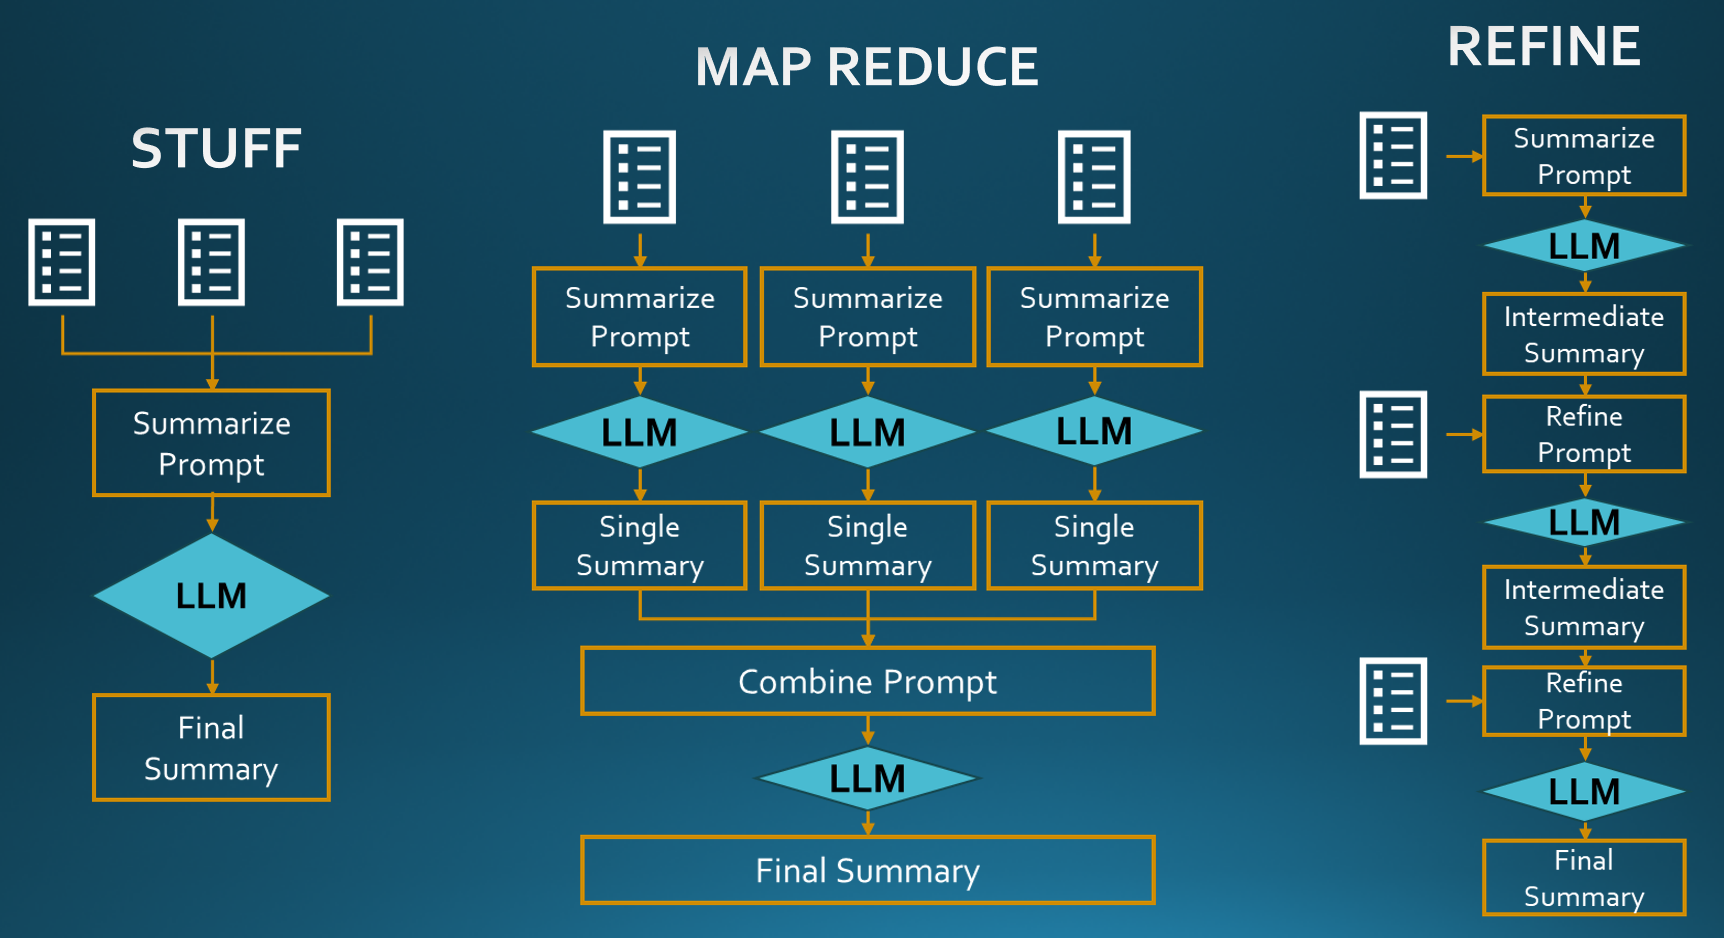

In [ ]:
# Initialize Map Reduce Chain
mapreduce_summarize_chain = load_summarize_chain(
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, max_tokens=512),
    map_prompt = custom_summarize_prompt, # Prompt to summarize individual document,
    combine_prompt = custom_summarize_prompt, # Prompt to combine individual summaries
    chain_type = "map_reduce", # Set chain_type to map_reduce
    verbose = True)

mapreduce_summary = mapreduce_summarize_chain(inputs = all_meetings)
print(mapreduce_summary["output_text"])

# Example 3: Retrieval Augmented Generation Question Answering with Langchain

One fundamental weakness of LLMs is that their knowledge is limited by the data used to train the models. Hence LLMs do not have access to information after knowledge cutoff as well as knowledge outside of its training data (e.g. specific domain data)

Currently, there are 2 main ways to address this problem:
1. Fine-Tune the LLM with latest data
2. In-Context Learning: Provide the LLM with the updated information inside the prompt.

Fine-Tuning is effective but is also very costly in terms of computation and data preparation. In addition, it doesn't solve the problem of un-updated knowledge base, as models fine-tuned today may be outdated a year later and need to be fine-tuned again.

In-Context Learning hence is an attractive solution to allows LLMs to have access to latest data at the point of running. In addition, it has been shown that models provided with contexts tend to have their answers grounded and less likely to hallucinate.

In this exercise, we will build a system to retrieval relevant data from a vector database and provide the data to the LLMs as context.

Before that, let's test a basic LLM model on a medical question specific to a disease and patient condition.

In [ ]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

basic_prompt = """Answer the following question as best as you can. If you do not know the answer, say I don't know.

Quesion: {question}
"""

basic_chain = LLMChain(
    llm=ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, max_tokens = 512),
    prompt = PromptTemplate.from_template(basic_prompt)
)

basic_chain("What is the recommended colonoscopy screening for Polyp patients with history of family members having Colon Cancer Syndrome X?")

{'question': 'What is the recommended colonoscopy screening for Polyp patients with history of family members having Colon Cancer Syndrome X?',
 'text': "I don't know."}

We can see that the LLM cannot answer such a specific question related to the medical domain

## Create Vector database

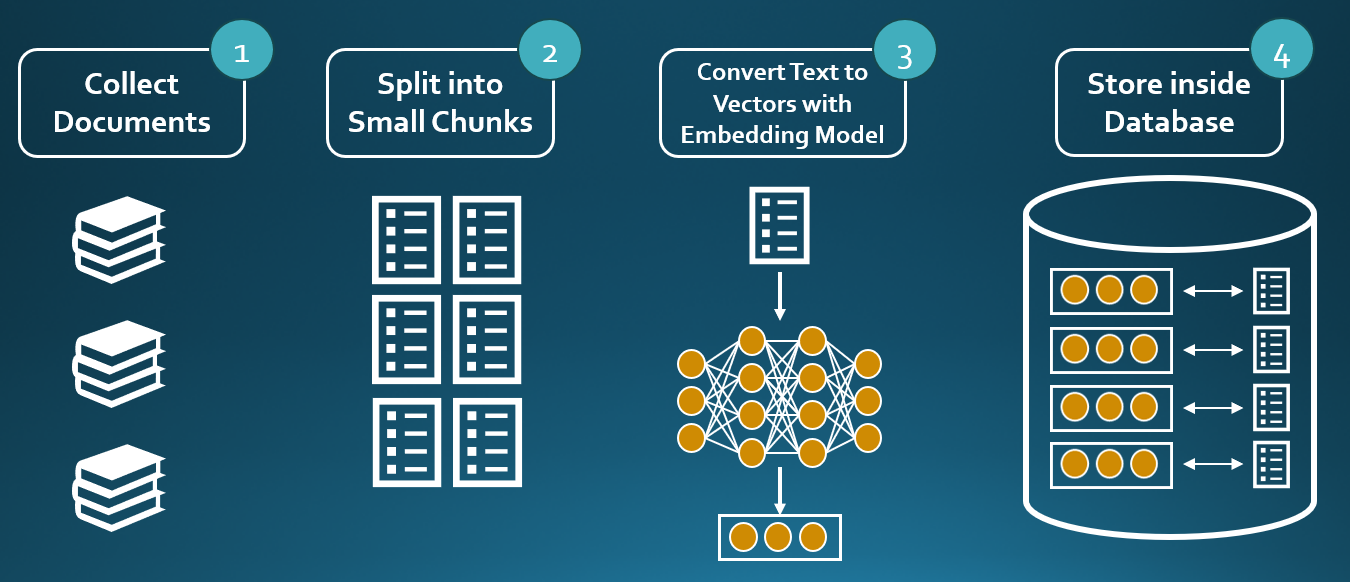

- We will create a vector index database using Facebook AI Similarity Search Database. Facebook AI Similarity Search (Faiss) is a library for efficient similarity search and clustering of dense vectors.

- We use OpenAIEmbeddings model to convert the texts into the vector representations which will be used for similarity search.
- Typically, the loaded documents are further split into smaller text chunks with some overlapping window (to keep some contextual information between chunks). The size and overlapping window of the text chunk is a parameter for tuning.

In [31]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

In [32]:
document_files = [os.path.join(MAIN_DIR, "example3", path) for path in os.listdir(os.path.join(MAIN_DIR, "example3"))] # Get all PDF document directories
documents = []
for doc_file in document_files:
     documents.extend(PyMuPDFLoader(doc_file).load()) # Convert all pdf files into list of documents

text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=500) # Split document into smaller chunks. Each chunk containing ~600-700 tokens
texts = text_splitter.split_documents(documents) # Split document into smaller chunks. Each chunk containing ~600-700 tokens
print("Number of text chunks:", len(texts))

embeddings = OpenAIEmbeddings() # Initiate Embedding Model
docsearch = FAISS.from_documents(texts, embeddings) # Run all texts chunks through embedding model and build database
docsearch.save_local(os.path.join(MAIN_DIR, "vectorstore")) # Save Database
print("Document Store saved successfully!!!")

Number of text chunks: 1609
0
Document Store saved successfully!!!


If you have already built a database, you can simply load it by providing the directory to the database folder.

In [ ]:
docsearch = FAISS.load_local(os.path.join(MAIN_DIR, "vectorstore"), OpenAIEmbeddings()) # Load the created database
print("Document Store loaded successfully!!!")

Document Store loaded successfully!!!


## Similarity Search
Once the database is created, we can input a query and ask the database to return the most relevant documents to our query.

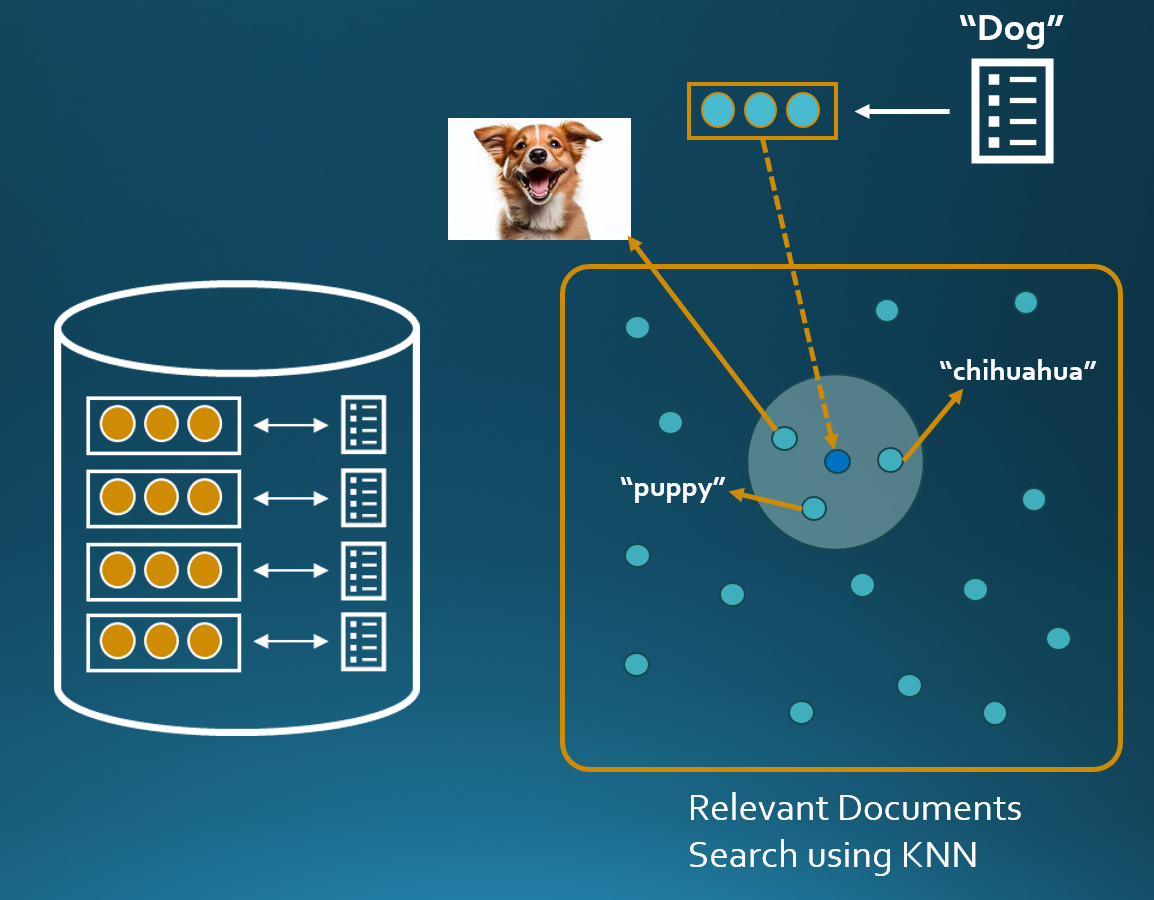


By default, the implementation of FAISS in Langchain uses Eucleadean distance (L2) as the distance measurement.

In [34]:
relevant_docs = docsearch.similarity_search("What is the recommended colonoscopy screening for Polyp patients with history of family members having Colon Cancer Syndrome X?",
                                            k=2)
for idx, relevant_doc in enumerate(relevant_docs):
    print(f"\nDocument {idx + 1}\n", relevant_doc.page_content)


Document 1
 Family history
Recommended screening
Lynch Syndrome
See reference 34
Family Colon Cancer Syndrome X
Colonoscopy every 3-5 years beginning 10 years before the age at
diagnosis of the youngest affected relative
Colorectal cancer or an advanced adenoma in two
ﬁrst-degree relatives diagnosed at any age
OR colorectal cancer or an advanced adenoma
in a single ﬁrst-degree relative at age < 60 years
Colonoscopy every 5 years beginning 10 years before the age
at diagnosis of the youngest affect interval or age 40,
whichever is earlier; for those with a single ﬁrst-degree
relative with colorectal cancer in whom no signiﬁcant
neoplasia appears by age 60 years, physicians can offer
expanding the interval between colonoscopies
Colorectal cancer or an advanced adenoma in a
single ﬁrst-degree relative diagnosed at
age � 60 years
Begin screening at age 40 years; tests and intervals are as
per the average-risk screening recommendations (Table 4)
10
Rex et al
Gastroenterology Vol. -, No. -


## Question Answering with Vectorsearch

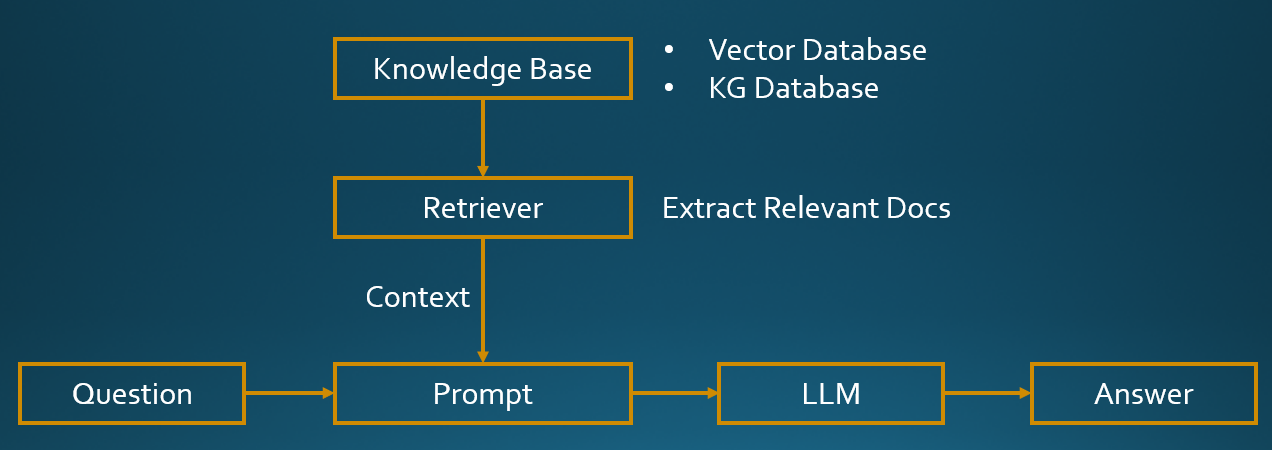

Now we will create a RetrievalQAWithSourcesChain which will integrate our QA from docs with the vector database. <br>

Under the hood, the retriever will retrieve/filter the most relevant documents from the database before stuffing it inside our context placeholder.

In [35]:
from langchain.chains.qa_with_sources.retrieval import RetrievalQAWithSourcesChain

qasource_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, max_tokens=512),
    chain_type="stuff",
    retriever=docsearch.as_retriever(search_kwargs={"k": 2}), # k is the number of documents to retrieve from
    return_source_documents=True, # Return Source documents
    reduce_k_below_max_tokens=False, # If True, the chain will automatically select the number of documents to below max_tokens. Default to 3375 tokens.
    verbose=True
)

Let's Investigate the Prompt

In [36]:
print(qasource_chain.combine_documents_chain.llm_chain.prompt.template)

Given the following extracted parts of a long document and a question, create a final answer with references ("SOURCES"). 
If you don't know the answer, just say that you don't know. Don't try to make up an answer.
ALWAYS return a "SOURCES" part in your answer.

QUESTION: Which state/country's law governs the interpretation of the contract?
Content: This Agreement is governed by English law and the parties submit to the exclusive jurisdiction of the English courts in  relation to any dispute (contractual or non-contractual) concerning this Agreement save that either party may apply to any court for an  injunction or other relief to protect its Intellectual Property Rights.
Source: 28-pl
Content: No Waiver. Failure or delay in exercising any right or remedy under this Agreement shall not constitute a waiver of such (or any other)  right or remedy.

11.7 Severability. The invalidity, illegality or unenforceability of any term (or part of a term) of this Agreement shall not affect the con

In [37]:
answer_from_source = qasource_chain("What is the recommended colonoscopy screening for Polyp patients with history of family members having Colon Cancer Syndrome X?")



> Entering new RetrievalQAWithSourcesChain chain...

> Finished chain.
3087


In [ ]:
pprint("Answer: "+answer_from_source["answer"])

('Answer: For patients with a history of family members having Colon Cancer '
 'Syndrome X, the recommended colonoscopy screening is every 3-5 years '
 'beginning 10 years before the age at diagnosis of the youngest affected '
 'relative. If there is a single first-degree relative with colorectal cancer '
 'at age <60 years, the recommended screening is every 5 years beginning 10 '
 'years before the age at diagnosis of the youngest affected relative or age '
 '40, whichever is earlier. If there is a single first-degree relative '
 'diagnosed at age ≥60 years, screening should begin at age 40 years and '
 'follow the average-risk screening recommendations. \n')


The answer seems accurate based on the documents retrieved. We can also check the document sources which the retriever feed to the LLMs.

In [ ]:
for idx, document in enumerate(answer_from_source["source_documents"]):
    print(f"Document {idx + 1}:", answer_from_source["source_documents"][0].metadata["source"].split("/")[-1])
    pprint(document.page_content)
    print("\n")

Document 1: MSTF 2017 CRC Screening.pdf
('Family history\n'
 'Recommended screening\n'
 'Lynch Syndrome\n'
 'See reference 34\n'
 'Family Colon Cancer Syndrome X\n'
 'Colonoscopy every 3-5 years beginning 10 years before the age at\n'
 'diagnosis of the youngest affected relative\n'
 'Colorectal cancer or an advanced adenoma in two\n'
 'ﬁrst-degree relatives diagnosed at any age\n'
 'OR colorectal cancer or an advanced adenoma\n'
 'in a single ﬁrst-degree relative at age < 60 years\n'
 'Colonoscopy every 5 years beginning 10 years before the age\n'
 'at diagnosis of the youngest affect interval or age 40,\n'
 'whichever is earlier; for those with a single ﬁrst-degree\n'
 'relative with colorectal cancer in whom no signiﬁcant\n'
 'neoplasia appears by age 60 years, physicians can offer\n'
 'expanding the interval between colonoscopies\n'
 'Colorectal cancer or an advanced adenoma in a\n'
 'single ﬁrst-degree relative diagnosed at\n'
 'age � 60 years\n'
 'Begin screening at age 40 years;

Another example

In [38]:
answer_from_source = qasource_chain("For Lynch syndrome (LS) patients, what is the guidelines for screening for gastric cancer? What is the guidelines for Endometrial cancer?")



> Entering new RetrievalQAWithSourcesChain chain...

> Finished chain.
3491


In [ ]:
pprint("Answer: "+answer_from_source["answer"])

('Answer: For Lynch syndrome (LS) patients, the guidelines for screening for '
 'gastric cancer recommend baseline esophagogastroduodenoscopy (EGD) with '
 'gastric biopsy at age 30-35 years, and treatment of H. pylori infection when '
 'found. Ongoing surveillance every 3-5 years may be considered if there is a '
 'family history of gastric or duodenal cancer. For endometrial cancer, '
 'screening should be offered to women at risk for or affected with LS by '
 'endometrial biopsy and transvaginal ultrasound annually, starting at age 30 '
 'to 35 years before undergoing surgery or if surgery is deferred.\n')


In [ ]:
for idx, document in enumerate(answer_from_source["source_documents"]):
    print(f"Document {idx + 1}:", answer_from_source["source_documents"][0].metadata["source"].split("/")[-1])
    pprint(document.page_content)
    print("\n")

Document 1: ACG 2015 Hereditary GI Cancers.pdf
('Hereditary GI Cancer Syndromes\n'
 '© 2015 by the American College of Gastroenterology \n'
 'The American Journal of GASTROENTEROLOGY\n'
 ' \n'
 '225\n'
 ' Table 2  .  Summary of recommendations \n'
 ' Lynch syndrome (LS) \n'
 '  1. In individuals at risk for or affected with LS, screening for '
 'colorectal cancer by colonoscopy should be performed at least every 2 years, '
 'beginning \n'
 'between ages 20 and 25 years. Annual colonoscopy should be considered in '
 'conﬁ rmed mutation carriers (strong recommendation, moderate quality of \n'
 'evidence for screening, and very low quality of evidence for annual '
 'surveillance and age of initiation). \n'
 '  2. Colectomy with ileorectal anastomosis (IRA) is the preferred treatment '
 'of patients affected with LS with colon cancer or colonic neoplasia not '
 'controllable \n'
 'by endoscopy. Segmental colectomy is an option in patients unsuitable for '
 'total colectomy if regular posto

# 🏆 Congratulations

## Learning Resources

You can start your journey on building LLM applications with the following resources:

- [Langchain](https://python.langchain.com/docs/get_started/introduction.html): Main Documentation Page of Langchain<br>

- [Pinecone LLM Series](https://www.pinecone.io/learn/series/langchain/langchain-intro/): This is a series of tutorials created by the Pinecone team. They also have a series of video tutorials which are easy to follow and learn. Also a great source to learn about vector database.

- [OpenAI](https://platform.openai.com/docs/introduction): Documentations to use OpenAI API

- [HuggingFace](https://huggingface.co/docs/transformers/index): Using Open-Source LLM with Hugging Face Transformers

- [Llamaindex](https://www.llamaindex.ai): Another popular framework for building LLM applications. This framework focuses more Retrieval Augmented Generation (RAG) with vectorindex and knowledge graphs.